<a href="https://colab.research.google.com/github/elements72/Progetto-Deblur/blob/main/Progetto_Deblur_CN_LPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Progetto Deblur**

---

Un'azienda vuole commercializzare un dispositivo di acquisizione immagini, del quale si sa che acquisisce con rumore Gaussiano additivo e sfocatura Gaussiana.
Il modello è quindi:

\begin{align*}
    b = A x_{true} + \eta
\end{align*}

Dove $A \in \mathbb{R}^{mn}$ è la matrice di sfocamento, $\eta \sim \mathcal{N}(0, \sigma^2)$ rumore additivo con varianza $\sigma^2$ incognita, $b \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine corrotta (acquisita) $B \in \mathbb{R}^{m \times n}$, $x_{true} \in \mathbb{R}^{mn}$ è la vettorizzazione dell'immagine originale $X_{true} \in \mathbb{R}^{m \times n}$.


1. Dopo aver importato le librerie necessarie, assegnare ad una variabile $X$ l'immagine $\texttt{cameraman}$, ottenibile tramite la libreria $\texttt{skimage.data}$ con il nome di $\texttt{camera()}$, effettuarne il $\texttt{reshape}$ e assegnarlo alla variabile $x$.

2. Tramite la funzione $\texttt{skimage.filters.gaussian}$ aggiungere sfocatura Gaussiana ad $X$ per ottenere $X_{blur}$, che rappresenta il reshape ad immagine di $x_{blur} = A x_{true}$, con $A$ matrice di sfocatura.

3. Caricare su una variabile $\eta$, della stessa dimensione di $X_{true}$, una realizzazione di rumore gaussiano con varianza $\sigma = 0.1$ (fare riferimento alle slides per la formula). 
Utilizzare $\eta$ per corrompere l'immagine $X_{blur}$ e calcolare $B = X_{blur} + \eta$. \\
Visualizzare i risultati ottenuti.

In [ ]:
def gkern(kernlen, nsig):
  """
  Genera un kernel per la realizzazione di un filtro di sfocatura Gaussiana.

  Input ->
  kernlen: diametro della sfocatura gaussiana.
  nsig:    varianza della sfocatura. Più basso, più sfoca.

  Output -> Kernel Gaussiano di dimensione (kernlen+1) x (kernlen+1) e varianza nsig.
  """
  import scipy.stats as st

  x = np.linspace(-nsig, nsig, kernlen+1)
  kern1d = np.diff(st.norm.cdf(x))
  kern2d = np.outer(kern1d, kern1d)
  return kern2d/kern2d.sum()

def A(x, d=15, sigma=0.5):
  """
  Esegue il prodotto Ax, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K = gkern(d, sigma)
  K_ext[:d, :d] = K
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(K_ext * x))

def AT(x, d=15, sigma=0.5):
  """
  Esegue il prodotto A^T x, dove A è la matrice di sfocamento (che, per aumentare l'efficienza, non viene memorizzata).
  
  Input ->
  x:     Immagine di dimensione m x n, che si vuole sfocare.
  d:     Diametro della sfocatura Gaussiana.
  sigma: Varianza della sfocatura Gaussiana.
  
  Output -> Immagine di dimensione m x n, sfocata.
  """
  from scipy.signal import convolve2d
  from numpy import fft
  m, n = x.shape

  K_ext = np.zeros((m, n))
  K_ext[:d, :d] = gkern(d, sigma)
  K_ext = fft.fft2(K_ext)
  x = fft.fft2(x)

  return np.real(fft.ifft2(np.conj(K_ext) * x))

In [ ]:


def initialize(X, sigma=0.1):
  """
  La funzione initialize ci permette di eseguire le operzioni di blur+noise
  su un'immagine che noi scegliamo, ci viene fornito in outputl'immagine corotta
  ed il disturbo ottenuto
  Parameters
  -----------
  X: Immagine da corrompere
  """
  # 1
  m, n = X.shape
  x = X.reshape(m*n)


  # 2
  X_blur = A(X)
  x_blur = X_blur.reshape(m*n)#Immagine vettorizzata


  # 3
  # Generiamo il rumore eta
  eta = np.random.normal(size=X_blur.shape)
  eta /= np.linalg.norm(eta, 'fro')
  eta *= sigma * np.linalg.norm(X_blur,'fro')

  # Aggiungiamo il rumore all'immagine sfocata
  B = X_blur + eta
  b = B.reshape(m*n)

  # Visualizziamo i risultati
  plt.figure(figsize=(30, 10))

  ax1 = plt.subplot(1, 3, 1)
  ax1.imshow(X, cmap='gray')
  plt.title('Immagine Originale', fontsize=30)

  ax2 = plt.subplot(1, 3, 2)
  ax2.imshow(X_blur, cmap='gray')
  plt.title('Immagine Sfocata', fontsize=30)

  ax3 = plt.subplot(1, 3, 3)
  ax3.imshow(B, cmap='gray')
  plt.title('Immagine Corrotta', fontsize=30)
  plt.show()

  return (B, eta)

Il problema di ricostruire l'immagine originale partendo dalla sua corruzione $b$, si può riscrivere come un problema di ottimizzazione

\begin{align}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 \hspace{2cm} (1)
\end{align}

4. Risolvere il problema (1) utilizzando l'algoritmo di discesa del gradiente con scelta del passo tramite backtracking, ricordando che, se 
\begin{align*}
  f(x) = \frac{1}{2} ||Ax - b||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b)
\end{align*}
E chiamare la soluzione ottenuta $x_{naive}$.

5. Modificare l'algoritmo precedente a far restituire l'errore tra l'immagine ricostruita al passo $k$ e l'immagine originale, per ogni $k$. Visualizzare il grafico dell'errore, e individuare per quale valore di $k$ si ha semiconvergenza. Per tale valore, calcolare l'immagine ricostruita e chiamarla $x_{trunc}$.

In [ ]:
#Backtracking non funzionante non entra nel while per valori piccoli
#Dopo tot iterazioni l'errore inizia a salire
#b matrice con blur+noise il nostro termine noto
#A matrice che provoca il blur
#x vettore che 



def stampa_grafico(X, err_list, it, title):
  print("Errore minore: %f \t iterazione: %d" % (np.amin(err_list[:it]), np.argmin(err_list[:it])+1))
  plt.figure(figsize=(30, 10))
  ax1 = plt.subplot(1, 2, 1)
  ax1.imshow(X, cmap='gray')
  plt.title('Immagine Ripristina %s' % title, fontsize=30)
  ax2 = plt.subplot(1, 2, 2)
  valueX = range(1, it+1)
  ax2.plot(valueX, err_list[:it], label="error", marker="x")
  plt.xlabel("Iterazioni")
  plt.xticks(valueX)
  plt.title('Errore', fontsize=30)
  plt.grid()
  plt.legend()
  plt.show()
  


def grad(X, B, params):
  return AT(A(X)-B)

def f(x, b, params):
  return (np.linalg.norm(A(x)-b,2)**2)/2

def next_step(X, B, f, g, params): # backtracking procedure for the choice of the steplength
  """
  Funzione per il backtracking
  Parameters
  -----------
  X: matrice su cui applicare la funzione
  B: matrice noise+blur
  g: valore del gradiente
  reg: fattore di regolarizzazione
  """
  alpha=10
  rho = 0.5
  c1 =0.5
  gamma = rho*g.transpose().dot(g)
  while (f(X - alpha*g, B, params) > f(X ,B, params) - alpha*gamma).all():
      alpha = alpha*c1
  return alpha

def minimize(x, b, f, grad, params, original, ABSOLUTE_STOP, MAXIT):
  """
  Gradient descend per funzioni con parametro di regolarizzazione
  Parameters
  ------------
  x: vettore iniziale
  b: matrice nota
  f_reg: funzione con fattore di reg
  grad_reg: gradiente della funzione 
  params: parametri aggiuntivi per la funzione
  original: matrice originale
  ABSOLUTE_STOP: 
  MAXIT: iterazioni massime
  """
  step = 1
  k = 0
  err_list = np.zeros(MAXIT)
  g = grad(x, b, params)  #Gradiente calcolato
  while(np.linalg.norm(g)>ABSOLUTE_STOP and k < MAXIT):
      step = next_step(x, b, f, g, params)
      x_new = x - step*g
      g = grad(x_new, b, params)
      x = x_new
      err_list[k] = np.linalg.norm(original-x, 2)
      k = k+1
      print("Iterazione: ", k)
  return (x, err_list, k)


def xNaiveTrunc(X, B, X_start, ABSOLUTE_STOP, MAXIT):
  """
  Soluzioni calcolate usando il normale metodo del gradiente,
  la seconda soluzione si blocca al miglior risultato ottenuto dalla prima
  Parameters
  ----------
  X: matrice originale
  B: matrice corotta
  ABSOLUTE_STOP
  MAXIT: numero massimo di iterazioni
  """
  x_naive, err_list_naive, it_naive = minimize(X_start, B, f, grad,  None, X, ABSOLUTE_STOP, MAXIT)
  stampa_grafico(x_naive, err_list_naive, it_naive, "Naive")
  k_min = np.argmin(err_list_naive)+1
  x_trunc, err_list_trunc, it_trunc = minimize(X_start, B, f, grad,  None, X, ABSOLUTE_STOP, k_min)
  stampa_grafico(x_trunc, err_list_trunc, it_trunc, "Trunc")
  return (x_naive, x_trunc)
  

Per risolvere la semiconvergenza, si introduce il problema regolarizzato

\begin{align*}
  x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 \hspace{2cm} (2)
\end{align*}

con $\lambda > 0$ parametro di regolarizzazione.

6. Sfruttando il fatto che, se
\begin{align*}
f(x) = \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2, \hspace{10px} \nabla f(x) = A^T(Ax - b) + \lambda x
\end{align*}
Risolvere il problema (2) utilizzando l'algoritmo precedente per diversi valori di $\lambda$, e stimare il valore ottimale di $\lambda$ che minimizzi l'errore tra l'immagine ricostruita e l'immagine originale (metodo euristico per il parametro di regolarizzazione). Chiamare $x_{\lambda}$ tale soluzione. \\

7. Stimare il valore ottimale di $\lambda$ tramite principio di discrepanza, ovvero scegliere il più grande $\lambda$ tale che
\begin{align*}
  ||A x_\lambda - b||_2^2 \leq ||\eta||_2^2
\end{align*}
Dove $\eta$ è il rumore. Chiamare $x_\lambda^{disc}$ la soluzione ottenuta dal $\lambda$ calcolato con principio di discrepanza.
 

In [ ]:
#b matrice con blur+noise il nostro termine noto
#A matrice che provoca il blur
#x vettore che 


def print_info(X, err_list, it, params, title):
  for i in range(len(params)):
    print("Lambda %d: %f" % (i+1, params[i]))
  stampa_grafico(X, err_list, it, title)

#Funzione usata per cercare lambda
def f_search(X, B):
  return np.linalg.norm(A(X)-B,2)**2

def manual_search(X, B, original, f_reg, grad_reg, params, nReg):
  """
  Ricerca di lambda manuale
  Parameters
  -----------
  X: matrice di partenza usata per calcolare il miglior lambda
  B: matrice noise+blur
  original: matrice dell'immagine originale
  f_reg: funzione
  grad_reg: gradiente
  params: parametri aggiuntivi
  nReg: indice del fattore di regolarizzazione che si vuole ottimizzare
  """
  params[nReg] = 0.00005
  regs = [] #0.5, 0.25, 0.0625, 0.0005,
  lambda_min = params
  x_min, err_list, it = minimize(X, B, f_reg, grad_reg, params, original, ABSOLUTE_STOP, MAXIT) #Calcolo per il primo valore tra i papabali
  min = err_list[it-1]
  for i in regs:
    params[nReg] = i
    x_min, err_list, it = minimize(X, B, f_reg, grad_reg, params, original, ABSOLUTE_STOP, MAXIT)
    #Controllo se con il nuovo valore di lambda ottengo risultati migliori
    if min > err_list[it-1]:
      min = err_list[it-1]
      lambda_min = params
  return lambda_min


def search_lambda(X, B, noise, original, f_reg, grad_reg, params, nReg):
  """
  Ricerca di lambda automatica usando il principio di discreoanza.
  Parameters
  -----------
  X: matrice di partenza usata per calcolare il miglior lambda
  B: matrice noise+blur
  noise: rumore iniziale
  original: matrice dell'immagine originale
  f_reg: funzione
  grad_reg: gradiente
  params: parametri aggiuntivi
  nReg: indice del fattore di regolarizzazione che si vuole ottimizzare
  """
  params[nReg] = 1  #Fattore di regolarizzazione
  c = 0.0125
  noise = np.linalg.norm(noise, 2)**2
  x_lambda, err_list, it = minimize(X, B, f_reg, grad_reg, params, original, ABSOLUTE_STOP, MAXIT)
  while(f_search(x_lambda, B) > noise):
    params[nReg] = params[nReg]*c
    x_lambda, err_list, it = minimize(X, B, f_reg, grad_reg, params, original, ABSOLUTE_STOP, MAXIT)
  return params


def grad_reg(X, B, params):
  """
  Gradiente regolarizzato
  Parameters
  -----------
  X: matrice su cui applicare la funzione
  B: matrice noise+blur
  params: fattore di regolarizzazione
  """
  reg = params[0]
  return AT(A(X)-B) + reg*X


def f_reg(X, B, params):
  """
  Funzione regolarizzata
  Parameters
  -----------
  X: matrice su cui applicare la funzione
  B: matrice noise+blur
  params: fattore di regolarizzazione
  """
  reg = params[0]
  return (np.linalg.norm(A(X)-B,2)**2)/2 + reg/2*np.linalg.norm(X, 2)**2

def xLambda(X, B, X_start, ABSOLUTE_STOP, MAXIT):
  """
  Soluzione calcolato usando norma due, un fattore
  di regolarizzazione scelto tra una serie di valori
  Parameters
  ----------
  X: matrice originale
  B: matrice corotta
  ABSOLUTE_STOP
  MAXIT: numero massimo di iterazioni
  """
  #Ricerca manuale (punto 6)
  params = [1]
  params = manual_search(X_start, B, X, f_reg, grad_reg, params, 0) 
  x_lambda, err_list_lambda, it_lambda = minimize(X_start, B, f_reg, grad_reg, params, X, ABSOLUTE_STOP, MAXIT)
  print_info(x_lambda, err_list_lambda, it_lambda, params, "Lambda")
  return x_lambda

def xLambdaDisc(X, B, X_start, ABSOLUTE_STOP, MAXIT):
  """
  Soluzione calcolato usando norma due, un fattore
  di regolarizzazione calcolato attraverso discrepanza
  Parameters
  ----------
  X: matrice originale
  B: matrice corotta
  ABSOLUTE_STOP
  MAXIT: numero massimo di iterazioni
  """
  #Ricerca automatica (punto 7)
  if MAXIT > 100:
    MAXIT = round(MAXIT/4)
  else:
    MAXIT = round(MAXIT/2)
  params = [1]
  params = search_lambda(X_start, B, eta, X, f_reg, grad_reg, params, 0)
  x_lambda_disc, err_list_lambda_disc, it_lambda_disc = minimize(X_start, B, f_reg, grad_reg, params, X, ABSOLUTE_STOP, MAXIT)
  print_info(x_lambda_disc, err_list_lambda_disc, it_lambda_disc, params, "Lambda disc")
  return x_lambda_disc


8. Ripetere quanto fatto nel punto 6, utilizzando la norma 1 come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \lambda ||x||_1 \hspace{2cm} (3)
\end{align*}
Dove la funzione obiettivo ha gradiente
\begin{align*}
  A^T(Ax - b) + \lambda \hspace{2px} sign(x)
\end{align*}

In [ ]:
#b matrice con blur+noise il nostro termine noto
#A matrice che provoca il blur
#x vettore che 

#Gradiente regolarizzato
def grad_reg1(X, B, params):
  reg = params[0]
  return AT(A(X)-B) + reg*np.sign(X)
#Funzione regolarizzara
def f_reg1(X, B, params):
  reg = params[0]
  return (np.linalg.norm(A(X)-B,2)**2)/2 + reg/2*np.linalg.norm(X, 1)**2


def xLambda1(X, B, X_start, ABSOLUTE_STOP, MAXIT):
  """
  Soluzione calcolato usando norma uno, un fattore
  di regolarizzazione scelto tra una serie di valori
  Parameters
  ----------
  X: matrice originale
  B: matrice corotta
  ABSOLUTE_STOP
  MAXIT: numero massimo di iterazioni
  """
  params = [1]
  params = manual_search(X_start, B, X, f_reg1, grad_reg1, params, 0)
  x_lambda1, err_list_lambda1, it_lambda1 = minimize(X_start, B, f_reg1, grad_reg1, params, X, ABSOLUTE_STOP, MAXIT)
  print_info(x_lambda1, err_list_lambda1, it_lambda1, params, "Lambda norma 1")
  return x_lambda1

def xLambdaDisc1(X, B, X_start, ABSOLUTE_STOP, MAXIT):
  """
  Soluzione calcolato usando norma uno, un fattore
  di regolarizzazione calcolato attraverso discrepanza
  Parameters
  ----------
  X: matrice originale
  B: matrice corotta
  ABSOLUTE_STOP
  MAXIT: numero massimo di iterazioni
  """
  #Ricerca automatica (punto 8)
  params = [1] 
  params = search_lambda(X_start, B, eta, X, f_reg1, grad_reg1, params, 0)
  x_lambda_disc1, err_list_lambda_disc1, it_lambda_disc1 = minimize(X_start, B, f_reg1, grad_reg1, params, X, ABSOLUTE_STOP, MAXIT)
  print_info(x_lambda_disc1, err_list_lambda_disc1, it_lambda_disc1, params, "Lambda disc norma 1")
  return x_lambda_disc1



9. ($\textit{facoltativo}$) Ripetere quanto fatto nei punti 6 e 8, utilizzando una norma mista come regolarizzatore, ovvero:
\begin{align*}
    x^* = \arg\min_x \frac{1}{2} ||Ax - b||_2^2 + \frac{\lambda}{2} ||x||_2^2 + \mu ||x||_1 \hspace{2cm} (4)
\end{align*}

In [ ]:

#Gradiente regolarizzato
def grad_reg2(X, B, params):

  reg = params[0]
  reg2 = params[1]
  return AT(A(X)-B) + reg2*np.sign(X) + reg*X
#Funzione regolarizzara
def f_reg2(X, B, params):
  reg = params[0]
  reg2 = params[1]
  return (np.linalg.norm(A(X)-B,2)**2)/2 + reg/2*np.linalg.norm(X, 2)**2 + reg2*np.linalg.norm(X, 1)

def xLambdaDisc2(X, B, X_start, ABSOLUTE_STOP, MAXIT):
  """
  Soluzione calcolato usando norma mista e due fattori 
  di regolarizzazione
  Parameters
  ----------
  X: matrice originale
  B: matrice corotta
  ABSOLUTE_STOP
  MAXIT: numero massimo di iterazioni
  """
  params = [1, 0]
  reg = search_lambda(X_start, B, eta, X, f_reg2, grad_reg2, params, 0) 
  reg = search_lambda(X_start, B, eta, X, f_reg2, grad_reg2, params, 1)
  x_lambda_disc2, err_list_lambda_disc2, it_lambda_disc2 = minimize(X_start, B, f_reg2, grad_reg2, params, X, ABSOLUTE_STOP, MAXIT)
  print_info(x_lambda_disc2, err_list_lambda_disc2, it_lambda_disc2, params, "Norma mista")
  return x_lambda_disc2


---

# Analisi dei risultati

---

Per ognuna delle soluzioni trovate, calcolare:

*   Errore relativo rispetto alla soluzione esatta $x_{true}$.
*   PSNR (Peak Signal to Noise Ratio).

Visualizzare le ricostruzioni ottenute con i vari metodi, e confrontare, sia numericamente che attraverso dei grafici, PSNR ed errore relativo ottenuti dalle ricostruzioni. Includere nel confronto, il valore delle metriche per l'immagine corrotta $b$.


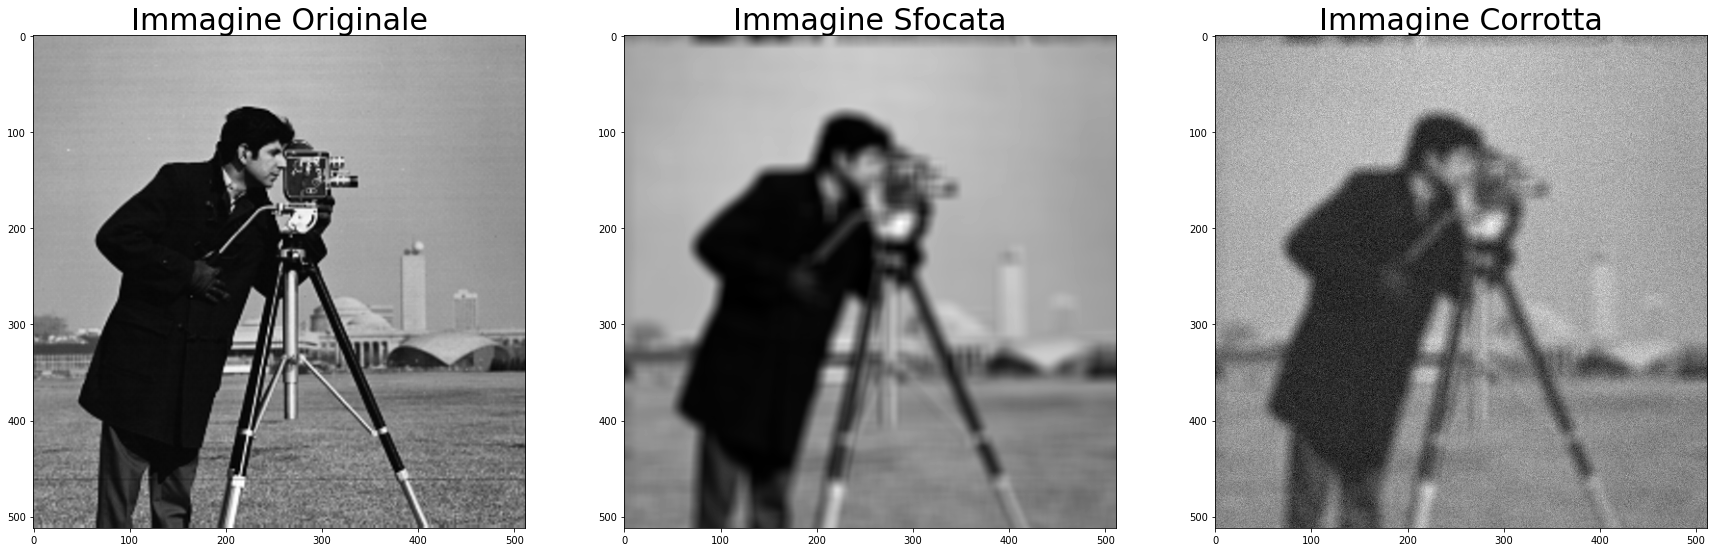

Iterazione:  1
Iterazione:  2
Iterazione:  3
Iterazione:  4
Iterazione:  5
Iterazione:  6
Iterazione:  7
Iterazione:  8
Iterazione:  9
Iterazione:  10
Iterazione:  11
Iterazione:  12
Iterazione:  13
Iterazione:  14
Iterazione:  15
Iterazione:  16
Iterazione:  17
Iterazione:  18
Iterazione:  19
Iterazione:  20
Iterazione:  21
Iterazione:  22
Iterazione:  23
Iterazione:  24
Iterazione:  25
Iterazione:  26
Iterazione:  27
Iterazione:  28
Iterazione:  29
Iterazione:  30
Iterazione:  31
Iterazione:  32
Iterazione:  33
Iterazione:  34
Iterazione:  35
Iterazione:  36
Iterazione:  37
Iterazione:  38
Iterazione:  39
Iterazione:  40
Iterazione:  41
Iterazione:  42
Iterazione:  43
Iterazione:  44
Iterazione:  45
Iterazione:  46
Iterazione:  47
Iterazione:  48
Iterazione:  49
Iterazione:  50
Iterazione:  51
Iterazione:  52
Iterazione:  53
Iterazione:  54
Iterazione:  55
Iterazione:  56
Iterazione:  57
Iterazione:  58
Iterazione:  59
Iterazione:  60
Iterazione:  61
Iterazione:  62
Iterazione:  63
I

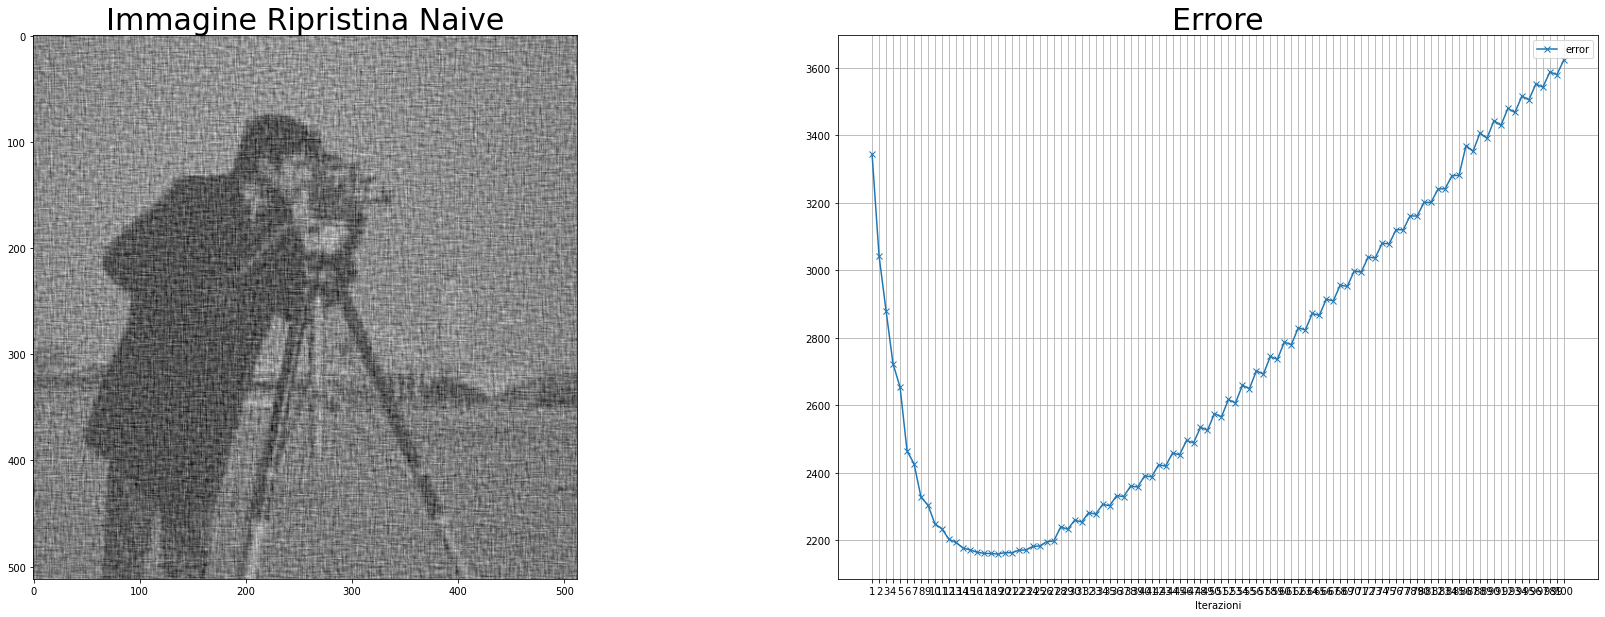

Iterazione:  1
Iterazione:  2
Iterazione:  3
Iterazione:  4
Iterazione:  5
Iterazione:  6
Iterazione:  7
Iterazione:  8
Iterazione:  9
Iterazione:  10
Iterazione:  11
Iterazione:  12
Iterazione:  13
Iterazione:  14
Iterazione:  15
Iterazione:  16
Iterazione:  17
Iterazione:  18
Iterazione:  19
Errore minore: 2158.947579 	 iterazione: 19


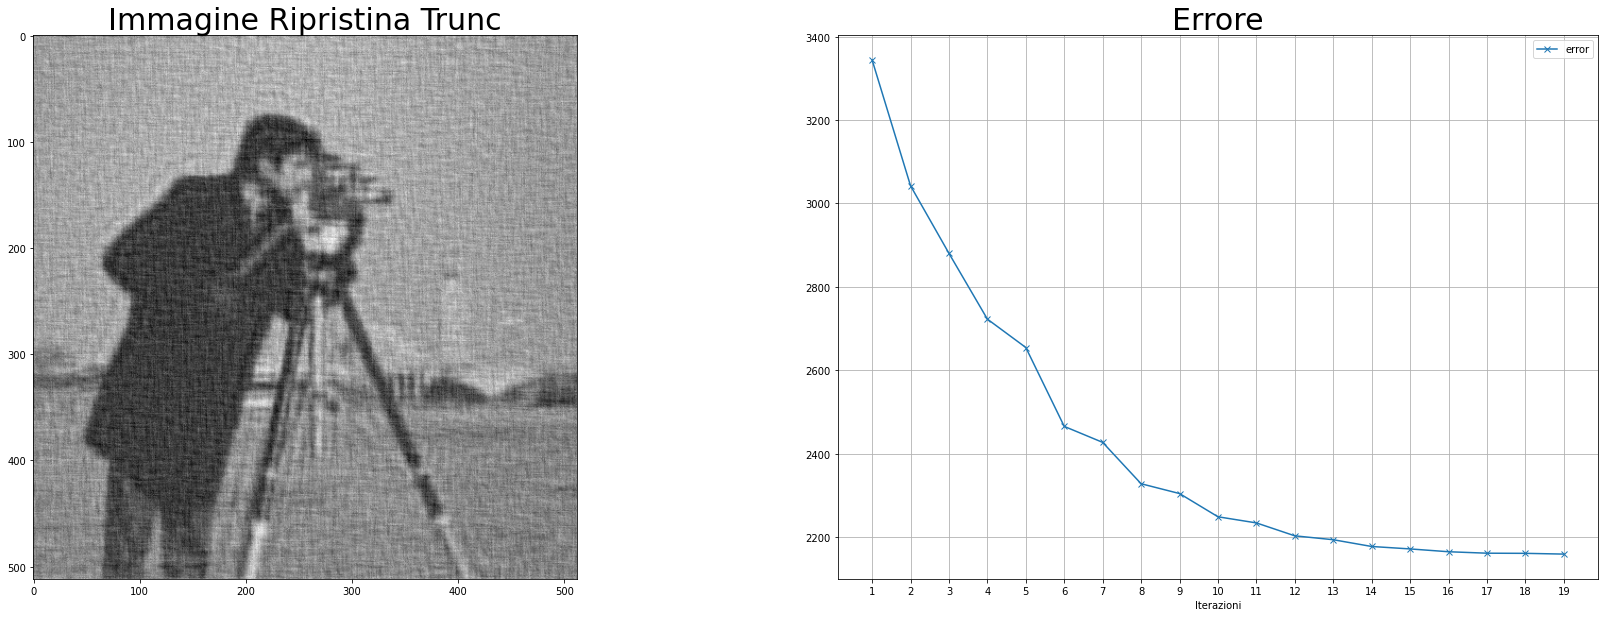

Iterazione:  1
Iterazione:  2
Iterazione:  3
Iterazione:  4
Iterazione:  5
Iterazione:  6
Iterazione:  7
Iterazione:  8
Iterazione:  9
Iterazione:  10
Iterazione:  11
Iterazione:  12
Iterazione:  13
Iterazione:  14
Iterazione:  15
Iterazione:  16
Iterazione:  17
Iterazione:  18
Iterazione:  19
Iterazione:  20
Iterazione:  21
Iterazione:  22
Iterazione:  23
Iterazione:  24
Iterazione:  25
Iterazione:  26
Iterazione:  27
Iterazione:  28
Iterazione:  29
Iterazione:  30
Iterazione:  31
Iterazione:  32
Iterazione:  33
Iterazione:  34
Iterazione:  35
Iterazione:  36
Iterazione:  37
Iterazione:  38
Iterazione:  39
Iterazione:  40
Iterazione:  41
Iterazione:  42
Iterazione:  43
Iterazione:  44
Iterazione:  45


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, io

def PSNR(x, x_true):
  MSE = np.mean((x_true-x)**2)
  return 20* np.log10(255/np.sqrt(MSE))

def print_errors(x_true, solutions, corrupted):
  """
  Funzione usata per stampare i vari errori relativi alle varie soluzioni
  """
  psnr_corrupted = PSNR(corrupted, x_true)
  rel_corrupted = np.linalg.norm(x_true - corrupted, 2)/np.linalg.norm(x_true,2)
  labels = ["naive", "trunc", "regolarizzato manualmente", "discrepanza", "norma mista manuale", "norma mista discrepanza", "doppia regolarizzazione"]
  for label, x , i in zip(labels, solutions, range(1, len(labels)+1)):
    plt.figure(figsize=(30, 10))
    rel = np.linalg.norm(x_true - x, 2)/np.linalg.norm(x_true,2)
    psnr = PSNR(x, x_true)
    print("Errore relativo %s: %f" % (label, rel))
    print("PSNR: %f" % psnr)
    print("PSNR corotta: %f" % psnr_corrupted)
    print("Errore relativo corotta: %f" % rel_corrupted)
    ax1 = plt.subplot(1, 2, 1)
    plt.title("Immagine %s" % label, fontsize=30)
    ax1.imshow(x, cmap="gray")
    ax2 = plt.subplot(1, 2, 2)
    plt.title("Immagine corotta", fontsize=30)
    ax2.imshow(corrupted, cmap="gray")
    plt.show()
  

ABSOLUTE_STOP = 0.002
MAXIT = 100
#X = data.page()    #Immagine con testo
X = data.camera() #Immagine di test
#X = data.checkerboard()  #Scacchiera
#X = io.imread("cerignola-buona.jpg", as_gray=True)


eta = 0.1

B, eta = initialize(X, eta)

x_naive, x_trunc = xNaiveTrunc(X, B, B, ABSOLUTE_STOP, MAXIT)
#solutions = [x_naive, x_trunc, xLambda(X, B, B, ABSOLUTE_STOP, MAXIT), xLambdaDisc(X, B, B, ABSOLUTE_STOP, MAXIT), xLambda1(X, B, B,ABSOLUTE_STOP, MAXIT), xLambdaDisc1(X, B, B, ABSOLUTE_STOP, MAXIT), xLambdaDisc2(X, B, B, ABSOLUTE_STOP, MAXIT)]
xLambdaDisc2(X, B, B, ABSOLUTE_STOP, MAXIT)
print_errors(X, solutions, B)
  


Ripetere tutti i passaggi, variando il livello del rumore (controllato dalla variabile $\sigma$), i parametri del kernel di sfocamento Gaussiano, e l'immagine di test. \\
Per la scelta delle immagini di test, utilizzare immagini **in bianco e nero, a scelta**, prese da internet, che rispettino i seguenti criteri:


*   Almeno un'immagine "geometrica", ovvero con pochi dettagli e contorni netti e ben contrastati (es. QRCode, Codice a Barre, Scacchiera...).
*   Almeno un'immagine "fotografica", ovvero con molti dettagli e livelli di grigio sfocati.
*   Almeno un'immagine contenente del testo, che diventerà difficilmente leggibile dopo il processo di sfocamento.


Osservare quale metodo di ricostruzione si comporta meglio nei vari esperimenti, ricordandosi corrompere l'immagine di input sia con rumore Gaussiano che con sfocatura.

